LSTM for expressive dynamics prediction
---------------

This notebook loads the data generated from the pre-processing notebook and uses them to train and test a long short-term memory artificial neural network for predicting the three parabolic coefficients that approximate the dynamics of phrases from the dataset pieces.


#### Load and preprocess training data

In [81]:
import numpy as np
import pandas as pd

np.random.seed(1728)

#  read csv
fhandle = open('data/violin.csv', 'r')
df = pd.read_csv(fhandle)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
print('initial size: ' + str(len(df)))

# eliminate missing values, insufficient dynamics data (dynamicsX0 = -inf)
df.dropna()
df = df.loc[df.dynamicsX0 != -np.inf,:]

print('size after N/A crop: ' + str(len(df)))

initial size: 25516
size after N/A crop: 25495


In [82]:
def sequencer(df):
    #  list the pieces
    pieces = set(df.pieceId)
    sequences = []
    maxLen = 0
    for p in pieces:
        d = df.loc[df.pieceId == p, :]
        #  use only the smaller phrases
        d = d.loc[np.concatenate((np.asarray([True]),(np.diff(d.locationInPiece) > 1e-7))), :]
        #d = d.loc[d.motifId.map(lambda x: x.split('_')[-1]) == '0', :]
        maxLen = len(d) if len(d) > maxLen else maxLen
        d = d.drop(['pieceId', 'motifId', 'pieceDynMean', 'pieceDynStd', 'pieceKey', 'startTime', 'durationSecs'], axis=1)
        #  standardize features
        moments = np.zeros((3,2)) # output mean and std for reverting predictions
        outs = d.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']]
        moments[:,0] = outs.mean().to_numpy()
        moments[:,1] = outs.std().to_numpy()
        nums = d.loc[:,(d.dtypes == 'float64') | (d.dtypes == 'int64')]
        d.loc[:, (d.dtypes == 'float64') | (d.dtypes == 'int64')] = (nums - nums.mean()) / nums.std()
        y = d.loc[:, ['dynamicsX2','dynamicsX1','dynamicsX0']]
        d = d.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1)
        sequences.append((moments, d, y))
    X = np.full((len(sequences), maxLen, len(sequences[0][1].columns)), -1e4, dtype='float64')
    Y = np.full((len(sequences), maxLen, len(sequences[0][2].columns)), 0, dtype='float64')
    moments = np.zeros((len(sequences), 3, 2))
    pd_idx = np.full((len(sequences), maxLen), -1e4, dtype='int32')
    for i, s in enumerate(sequences):
        (mm, x, y) = s
        X[i, 0:len(x), :] = x
        Y[i, 0:len(y), :] = y
        moments[i, :, :] = mm
        pd_idx[i, 0:len(x)] = x.index
    return X, Y, moments, pd_idx
        
def filter_outliers(df, cols=None, outlier_factor=5.):
    if cols is None:
        cols = (df.dtypes == 'float64') | (df.dtypes == 'int64')
    numdf = df.loc[:, cols]
    thold = outlier_factor * (numdf.quantile(0.75) - numdf.quantile(0.25))
    return df[((numdf - thold) < 0).all(axis=1)]

#  one-hot encode nominal values
for attrib in ['metricStrength', 'pieceMode', 'initialChord', 'finalChord']:
    df = pd.concat([df, pd.get_dummies(df[attrib], prefix=attrib)], axis=1)
    df.drop([attrib], axis=1, inplace=True)

#  make data sequential 
X, Y, moments, pd_idx = sequencer(df)
print("dataset size: " + str(X.shape))

dataset size: (122, 291, 47)


#### Define the neural network

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, BatchNormalization, Dense, TimeDistributed

model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(32, return_sequences = True)),
    Dropout(0.8),
    BatchNormalization(),
    TimeDistributed(Dense(3)),
    BatchNormalization()])

#opt = keras.optimizers.Adam(learning_rate=0.01, clipnorm=1)
model.compile(loss="mean_absolute_error", optimizer='adam')

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 291, 64)           20480     
_________________________________________________________________
dropout_13 (Dropout)         (None, 291, 64)           0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 291, 64)           256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 291, 3)            195       
_________________________________________________________________
batch_normalization_22 (Batc (None, 291, 3)            12        
Total params: 20,943
Trainable params: 20,809
Non-trainable params: 134
_________________________________________________________________


#### Train the model

In [84]:
model.fit(X[10:,:,:], Y[10:,:,:], epochs=600, validation_split=0.1)

Epoch 1/600
4/4 [==============================] - 2s 447ms/step - loss: 0.8312 - val_loss: 0.6902
Epoch 2/600
4/4 [==============================] - 1s 202ms/step - loss: 0.8120 - val_loss: 0.7072
Epoch 3/600
4/4 [==============================] - 1s 199ms/step - loss: 0.7883 - val_loss: 0.7670
Epoch 4/600
4/4 [==============================] - 1s 192ms/step - loss: 0.7747 - val_loss: 0.6551
Epoch 5/600
4/4 [==============================] - 1s 188ms/step - loss: 0.7521 - val_loss: 0.5692
Epoch 6/600
4/4 [==============================] - 1s 198ms/step - loss: 0.7216 - val_loss: 0.4158
Epoch 7/600
4/4 [==============================] - 1s 199ms/step - loss: 0.6863 - val_loss: 0.4077
Epoch 8/600
4/4 [==============================] - 1s 212ms/step - loss: 0.6753 - val_loss: 0.3999
Epoch 9/600
4/4 [==============================] - 1s 207ms/step - loss: 0.6558 - val_loss: 0.3585
Epoch 10/600
4/4 [==============================] - 1s 199ms/step - loss: 0.6403 - val_loss: 0.3473
Epoch 11/

4/4 [==============================] - 1s 209ms/step - loss: 0.4499 - val_loss: 0.4396
Epoch 84/600
4/4 [==============================] - 1s 217ms/step - loss: 0.4526 - val_loss: 0.4077
Epoch 85/600
4/4 [==============================] - 1s 208ms/step - loss: 0.4569 - val_loss: 0.4178
Epoch 86/600
4/4 [==============================] - 1s 199ms/step - loss: 0.4656 - val_loss: 0.4237
Epoch 87/600
4/4 [==============================] - 1s 197ms/step - loss: 0.4496 - val_loss: 0.3842
Epoch 88/600
4/4 [==============================] - 1s 217ms/step - loss: 0.4474 - val_loss: 0.3762
Epoch 89/600
4/4 [==============================] - 1s 221ms/step - loss: 0.4569 - val_loss: 0.3917
Epoch 90/600
4/4 [==============================] - 1s 200ms/step - loss: 0.4535 - val_loss: 0.3815
Epoch 91/600
4/4 [==============================] - 1s 189ms/step - loss: 0.4513 - val_loss: 0.3751
Epoch 92/600
4/4 [==============================] - 1s 193ms/step - loss: 0.4508 - val_loss: 0.4249
Epoch 93/600


4/4 [==============================] - 1s 195ms/step - loss: 0.3379 - val_loss: 0.3404
Epoch 165/600
4/4 [==============================] - 1s 212ms/step - loss: 0.3378 - val_loss: 0.3347
Epoch 166/600
4/4 [==============================] - 1s 212ms/step - loss: 0.3344 - val_loss: 0.3314
Epoch 167/600
4/4 [==============================] - 1s 218ms/step - loss: 0.3317 - val_loss: 0.3288
Epoch 168/600
4/4 [==============================] - 1s 218ms/step - loss: 0.3297 - val_loss: 0.3247
Epoch 169/600
4/4 [==============================] - 1s 208ms/step - loss: 0.3302 - val_loss: 0.3219
Epoch 170/600
4/4 [==============================] - 1s 195ms/step - loss: 0.3280 - val_loss: 0.3189
Epoch 171/600
4/4 [==============================] - 1s 218ms/step - loss: 0.3261 - val_loss: 0.3164
Epoch 172/600
4/4 [==============================] - 1s 209ms/step - loss: 0.3259 - val_loss: 0.3146
Epoch 173/600
4/4 [==============================] - 1s 219ms/step - loss: 0.3331 - val_loss: 0.3133
Epoc

4/4 [==============================] - 1s 223ms/step - loss: 0.2966 - val_loss: 0.2927
Epoch 246/600
4/4 [==============================] - 1s 211ms/step - loss: 0.2976 - val_loss: 0.2926
Epoch 247/600
4/4 [==============================] - 1s 218ms/step - loss: 0.2972 - val_loss: 0.2927
Epoch 248/600
4/4 [==============================] - 1s 222ms/step - loss: 0.2972 - val_loss: 0.2926
Epoch 249/600
4/4 [==============================] - 1s 302ms/step - loss: 0.2970 - val_loss: 0.2935
Epoch 250/600
4/4 [==============================] - 1s 261ms/step - loss: 0.2968 - val_loss: 0.2946
Epoch 251/600
4/4 [==============================] - 1s 214ms/step - loss: 0.2965 - val_loss: 0.2948
Epoch 252/600
4/4 [==============================] - 1s 225ms/step - loss: 0.2974 - val_loss: 0.2936
Epoch 253/600
4/4 [==============================] - 1s 207ms/step - loss: 0.2962 - val_loss: 0.2928
Epoch 254/600
4/4 [==============================] - 1s 211ms/step - loss: 0.2950 - val_loss: 0.2926
Epoc

4/4 [==============================] - 1s 199ms/step - loss: 0.2852 - val_loss: 0.2856
Epoch 327/600
4/4 [==============================] - 1s 214ms/step - loss: 0.2852 - val_loss: 0.2856
Epoch 328/600
4/4 [==============================] - 1s 217ms/step - loss: 0.2848 - val_loss: 0.2844
Epoch 329/600
4/4 [==============================] - 1s 211ms/step - loss: 0.2856 - val_loss: 0.2842
Epoch 330/600
4/4 [==============================] - 1s 225ms/step - loss: 0.2847 - val_loss: 0.2852
Epoch 331/600
4/4 [==============================] - 1s 220ms/step - loss: 0.2832 - val_loss: 0.2857
Epoch 332/600
4/4 [==============================] - 1s 222ms/step - loss: 0.2841 - val_loss: 0.2851
Epoch 333/600
4/4 [==============================] - 1s 212ms/step - loss: 0.2838 - val_loss: 0.2846
Epoch 334/600
4/4 [==============================] - 1s 212ms/step - loss: 0.2837 - val_loss: 0.2849
Epoch 335/600
4/4 [==============================] - 1s 202ms/step - loss: 0.2847 - val_loss: 0.2850
Epoc

4/4 [==============================] - 1s 231ms/step - loss: 0.2778 - val_loss: 0.2792
Epoch 408/600
4/4 [==============================] - 1s 232ms/step - loss: 0.2776 - val_loss: 0.2794
Epoch 409/600
4/4 [==============================] - 1s 209ms/step - loss: 0.2784 - val_loss: 0.2792
Epoch 410/600
4/4 [==============================] - 1s 201ms/step - loss: 0.2780 - val_loss: 0.2790
Epoch 411/600
4/4 [==============================] - 1s 214ms/step - loss: 0.2774 - val_loss: 0.2790
Epoch 412/600
4/4 [==============================] - 1s 197ms/step - loss: 0.2772 - val_loss: 0.2790
Epoch 413/600
4/4 [==============================] - 1s 222ms/step - loss: 0.2784 - val_loss: 0.2785
Epoch 414/600
4/4 [==============================] - 1s 224ms/step - loss: 0.2774 - val_loss: 0.2785
Epoch 415/600
4/4 [==============================] - 1s 225ms/step - loss: 0.2766 - val_loss: 0.2787
Epoch 416/600
4/4 [==============================] - 1s 225ms/step - loss: 0.2770 - val_loss: 0.2793
Epoc

4/4 [==============================] - 1s 215ms/step - loss: 0.2749 - val_loss: 0.2777
Epoch 489/600
4/4 [==============================] - 1s 208ms/step - loss: 0.2754 - val_loss: 0.2775
Epoch 490/600
4/4 [==============================] - 1s 202ms/step - loss: 0.2751 - val_loss: 0.2778
Epoch 491/600
4/4 [==============================] - 1s 203ms/step - loss: 0.2751 - val_loss: 0.2780
Epoch 492/600
4/4 [==============================] - 1s 226ms/step - loss: 0.2746 - val_loss: 0.2780
Epoch 493/600
4/4 [==============================] - 1s 221ms/step - loss: 0.2744 - val_loss: 0.2778
Epoch 494/600
4/4 [==============================] - 1s 213ms/step - loss: 0.2746 - val_loss: 0.2779
Epoch 495/600
4/4 [==============================] - 1s 219ms/step - loss: 0.2744 - val_loss: 0.2781
Epoch 496/600
4/4 [==============================] - 1s 212ms/step - loss: 0.2742 - val_loss: 0.2781
Epoch 497/600
4/4 [==============================] - 1s 216ms/step - loss: 0.2740 - val_loss: 0.2780
Epoc

4/4 [==============================] - 1s 204ms/step - loss: 0.2732 - val_loss: 0.2772
Epoch 570/600
4/4 [==============================] - 1s 216ms/step - loss: 0.2726 - val_loss: 0.2775
Epoch 571/600
4/4 [==============================] - 1s 202ms/step - loss: 0.2734 - val_loss: 0.2780
Epoch 572/600
4/4 [==============================] - 1s 228ms/step - loss: 0.2742 - val_loss: 0.2778
Epoch 573/600
4/4 [==============================] - 1s 205ms/step - loss: 0.2733 - val_loss: 0.2774
Epoch 574/600
4/4 [==============================] - 1s 228ms/step - loss: 0.2734 - val_loss: 0.2773
Epoch 575/600
4/4 [==============================] - 1s 215ms/step - loss: 0.2729 - val_loss: 0.2778
Epoch 576/600
4/4 [==============================] - 1s 220ms/step - loss: 0.2733 - val_loss: 0.2775
Epoch 577/600
4/4 [==============================] - 1s 204ms/step - loss: 0.2736 - val_loss: 0.2772
Epoch 578/600
4/4 [==============================] - 1s 204ms/step - loss: 0.2730 - val_loss: 0.2776
Epoc

#### Results

In [85]:
#  Compute correlation coefficients

#  Save model

valid_idx = pd_idx[1][pd_idx[1] > 0]
df.loc[valid_idx,['numberOfNotes', 'duration', 'locationInPiece', 'pieceId', 'motifId', 'boundaryValue']]

,numberOfNotes,duration,locationInPiece,pieceId,motifId,boundaryValue
17771,11,24.000000,0.000000,2562,0,1.000000
17772,10,8.000000,0.028419,2562,1,0.758988
17773,11,4.000000,0.037892,2562,2,0.328326
17774,16,10.000000,0.042629,2562,3,0.360089
17775,4,5.500000,0.054470,2562,4,0.320153
17778,17,7.000000,0.060983,2562,7,0.239505
17780,15,6.500000,0.061575,2562,9,0.181045
17782,3,1.000000,0.069272,2562,11,0.302339
17784,6,2.000000,0.070456,2562,13,0.569680
17785,20,7.000000,0.072824,2562,14,0.569680


In [6]:
#  Compute note-level error
Yhat = model.predict(X[0:10,:,:])
choice = 0
DynPiece = np.load('data/levels/'+ str(df.loc[pd_idx[choice][0], ['pieceId']]) + '_global_levels.npy')
valid_idx = pd_idx[choice][pd_idx[choice] > 0]
for phr in range(len(valid_idx)):
    duration = df.durationSecs[valid_idx[phr]]
    n = df.numberOfNotes[valid_idx[phr]]
    tref = np.linspace(0, 1, n)
    dyn = 
    endT = df.iloc[0,['']]
    




offset = train.shape[0]
def resultForIndex(i, source=test):
    intact_idx = test.index[i]
    lvls = np.load('data/levels/' + str(intact.pieceId[intact_idx]) + 'lvls.npy') # all piece levels
    lvls = lvls[intact.motifId[intact_idx]] # this phrase levels
    x = np.linspace(0, 1, len(lvls))
    ytest = intact.dynamicsX2[intact_idx]*x**2 + intact.dynamicsX1[intact_idx]*x + intact.dynamicsX0[intact_idx]
    net_input = test.iloc[i, :].drop(['dynamicsX2','dynamicsX1','dynamicsX0']).to_numpy().astype('float64')
    pred = net(torch.Tensor(net_input))
    pred = pred.detach().numpy()
    y = (pred[0]*moments[0,1]+moments[0,0])*x**2 + (pred[1]*moments[1,1]+moments[1,0])*x + (pred[2]*moments[2,1]+moments[2,0])
    return (lvls, ytest, y)

   
s = 50 # pred.shape[0]
msePred = np.zeros((s,1))
mseIdeal = np.zeros((s,1))
mseLvl = np.zeros((s,1))
for i in range(s):
    lvls, ytest, y = resultForIndex(i)
    mseIdeal[i] = np.sum((ytest - lvls)**2)
    msePred[i] = np.sum((y - lvls)**2)
    mseLvl[i] = np.sum(np.asarray(lvls)**2)
    
print('Ideal approximation note-level RMS Error: ' + str(np.sqrt(np.mean(mseIdeal))))
print('Prediction note-level RMS Error: ' + str(np.sqrt(np.mean(msePred))))
print('Mean performance RMS loudness: ' + str(np.sqrt(np.mean(mseLvl))))

Ideal approximation note-level RMS Error: 1.6891970918706487
Prediction note-level RMS Error: 3.3900648195643193
Mean performance RMS loudness: 3.8577704937926085


[875, 64, 324]


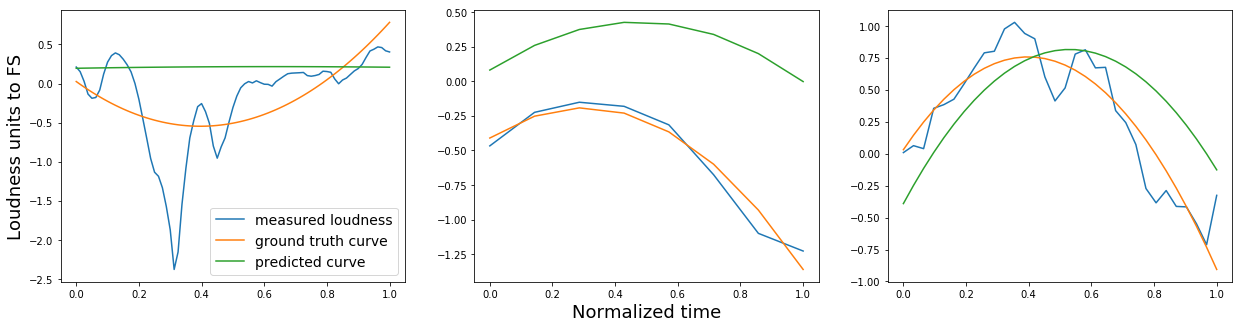

In [13]:
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(21, 5))
indexes = random.sample(range(0,len(test)),3)
print(indexes)

plt.subplot(131)
lvls, ytest, y = resultForIndex(indexes[0])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
plt.ylabel('Loudness units to FS', fontsize=18)
#plt.xlabel('Normalized time', fontsize=18)
plt.legend(loc='lower right', fontsize=14)

plt.subplot(132)
lvls, ytest, y = resultForIndex(indexes[1])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
#plt.ylabel('Loudness units to FS')
plt.xlabel('Normalized time', fontsize=18)

plt.subplot(133)
lvls, ytest, y = resultForIndex(indexes[2])
x = np.linspace(0, 1, len(lvls))
coefs = np.polyfit(x, lvls, 2)

ycalc = coefs[0]*x**2 + coefs[1]*x + coefs[2]
plt.plot(x, lvls, label='measured loudness')
plt.plot(x, ytest, label='ground truth curve')
plt.plot(x, y, label='predicted curve')
#plt.ylabel('Loudness units to FS', fontsize=18)
#plt.xlabel('Normalized time', fontsize=18)

plt.savefig('results/result')
plt.show()